## Loading modules and the dataset

In [2]:
# Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
import xgboost

In [3]:
# Dataset
original_df = pd.read_csv("data/train.csv", delimiter=",")

## Exploring the dataset
### Basics information

In [4]:
# Basic information (shape, ...)
print(f"Dataset shape : {original_df.shape}")
print(f"Number features : {original_df.shape[1]}")
print(f"Number sample : {original_df.shape[0]}")
original_df.info()

Dataset shape : (225000, 325)
Number features : 325
Number sample : 225000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225000 entries, 0 to 224999
Columns: 325 entries, _STATE to TARGET
dtypes: bool(1), float64(318), int64(6)
memory usage: 556.4 MB


In [ ]:
# Showing a bit of the dataset
original_df.head()

# Checking the number of benign (result = 0) and malware (result = 1) apps
benign_df = original_df[original_df["TARGET"] == 0]
malware_df = original_df[original_df["TARGET"] == 1]

print(f"False data shape : {benign_df.shape}")
print(f"True data shape : {malware_df.shape}")
print(malware_df.shape[0]/(benign_df.shape[0]+malware_df.shape[0]))

False data shape : (204861, 325)
True data shape : (20139, 325)
0.08950666666666666


In [6]:
# Pourcentage de valeurs manquantes par colonne
missing_percent = original_df.isna().mean() * 100

# Affichage propre, trié du plus manquant au moins manquant
missing_percent = missing_percent.sort_values(ascending=False)

print(missing_percent)

TOLDCFS     100.000000
HAVECFS     100.000000
WORKCFS     100.000000
COLGHOUS     99.994222
COLGSEX1     99.993778
               ...    
_TOTINDA      0.000000
_HCVU652      0.000000
_HLTHPLN      0.000000
_MENT14D      0.000000
TARGET        0.000000
Length: 325, dtype: float64


In [ ]:
# Calcul du pourcentage de valeurs manquantes par feature
missing_pct = original_df.isna().mean() * 100

# Définition des tranches (bins) de 0 à 100 par pas de 10
bins = np.arange(0, 101, 1)  # 0,10,20,...,100
labels = [f"{i}-{i+1}%" for i in range(0, 100, 1)]

# Catégorisation des features selon leur tranche de % de manquants
categories = pd.cut(missing_pct, bins=bins, labels=labels, right=False, include_lowest=True)

# Comptage du nombre de features dans chaque tranche
summary = categories.value_counts().sort_index()

# Transformation en DataFrame pour un rendu propre
missing_tranches_df = pd.DataFrame({
    'Tranche_%_manquants': summary.index,
    'Nb_features': summary.values
})

print(missing_tranches_df)

#Faire un histogramme 


   Tranche_%_manquants  Nb_features
0                 0-1%           85
1                 1-2%            1
2                 2-3%            2
3                 3-4%            2
4                 4-5%            3
..                 ...          ...
95              95-96%            5
96              96-97%            3
97              97-98%           34
98              98-99%           19
99             99-100%           13

[100 rows x 2 columns]


➡️ Colonnes conservées : 320 / 325


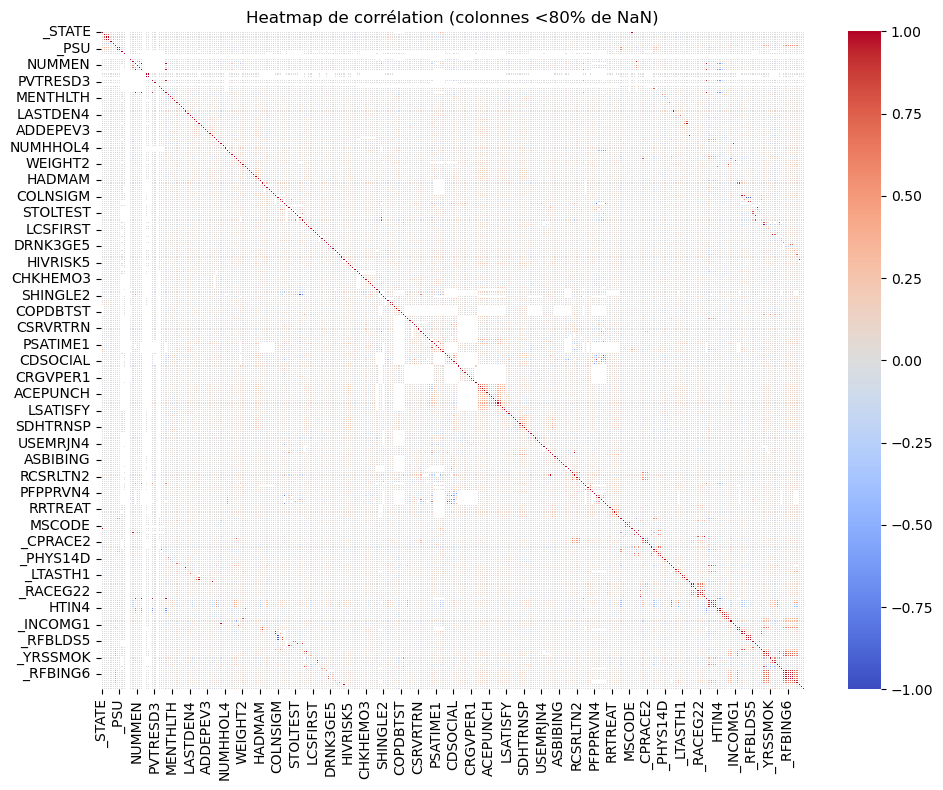

In [50]:
# Calcul du pourcentage de valeurs manquantes
missing_pct = original_df.isna().mean() * 100

# Suppression des colonnes avec plus de 99.9 % de valeurs manquantes
filtered_df = original_df.loc[:, missing_pct < 99.9]
print(f"➡️ Colonnes conservées : {filtered_df.shape[1]} / {original_df.shape[1]}")

# Calcul de la matrice de corrélation (uniquement numérique)
corr_matrix = filtered_df.corr(numeric_only=True)

# Création du heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    annot=False,       # mets True si tu veux afficher les valeurs
    linewidths=0.5
)
plt.title("Heatmap de corrélation (colonnes <80% de NaN)")
plt.tight_layout()
plt.show()


In [51]:
import pandas as pd
import numpy as np

# 1) Config
target_col = original_df.columns[-1]
print(f"🎯 Nom de la colonne Target : {target_col}")

# 2) % de valeurs manquantes (sur toutes les colonnes)
missing_pct = original_df.isna().mean() * 100

# 3) Conversion en numérique pour calculer la corrélation (Pearson)
#    - les colonnes non numériques deviennent NaN
df_num = original_df.apply(pd.to_numeric, errors='coerce')

# 4) Corrélation avec la Target (si convertible et au moins 2 valeurs non-NaN)
if target_col in df_num.columns and df_num[target_col].notna().sum() >= 2:
    corr_series = df_num.corr(numeric_only=True)[target_col]
else:
    corr_series = pd.Series(index=df_num.columns, dtype=float)

# 5) Tableau récapitulatif
summary = pd.DataFrame({
    'feature': original_df.columns,
    '%missing': missing_pct.reindex(original_df.columns).values,
    'corr_with_Target': corr_series.reindex(original_df.columns).values
})

# Option : retirer la ligne Target elle-même
summary = summary[summary['feature'] != target_col]

# 6) Tri : moins de valeurs manquantes d'abord, puis |corr| décroissante
summary = summary.sort_values(
    by=['%missing', 'corr_with_Target'],
    ascending=[True, False],
    key=lambda s: (np.abs(s) if s.name == 'corr_with_Target' else s)
).reset_index(drop=True)

print(summary)

# 7) Export CSV (optionnel)
summary.to_csv("features_missing_corr_target.csv", index=False)
print("✅ Exporté: features_missing_corr_target.csv")


🎯 Nom de la colonne Target : TARGET
      feature    %missing  corr_with_Target
0      _AGE80    0.000000          0.231371
1    _AGEG5YR    0.000000          0.222521
2      _AGE_G    0.000000          0.214506
3    _HCVU652    0.000000          0.194126
4    _AGE65YR    0.000000          0.184403
..        ...         ...               ...
319  COLGSEX1   99.993778          0.206725
320  COLGHOUS   99.994222               NaN
321   TOLDCFS  100.000000               NaN
322   HAVECFS  100.000000               NaN
323   WORKCFS  100.000000               NaN

[324 rows x 3 columns]
✅ Exporté: features_missing_corr_target.csv


In [52]:

# Filtrer uniquement les features avec |corr| > 0.1
filtered_summary = summary[summary['corr_with_Target'].abs() > 0.1]

# Trier par corrélation décroissante
filtered_summary = filtered_summary.sort_values(by='corr_with_Target', ascending=False).reset_index(drop=True)

# Afficher le résultat
print("✅ Features avec |corr(Target)| > 0.1 :")
print(filtered_summary)

✅ Features avec |corr(Target)| > 0.1 :
     feature   %missing  corr_with_Target
0     _AGE80   0.000000          0.231371
1   _AGEG5YR   0.000000          0.222521
2    GENHLTH   0.000444          0.222041
3     _AGE_G   0.000000          0.214506
4   COLGSEX1  99.993778          0.206725
5    EMPLOY1   1.439111          0.203364
6   _HCVU652   0.000000          0.194126
7   _AGE65YR   0.000000          0.184403
8   _PACKYRS  67.582667          0.168462
9   _YRSSMOK  66.520444          0.161509
10   _RFHLTH   0.000000          0.152469
11  _PACKDAY  65.851111          0.121894
12  CRVCLCNC  69.981778          0.105677
13  CHILDREN   2.155556          0.105020
14    QSTVER   0.000000         -0.101399
15  _SMOKGRP   8.182222         -0.115289
16  HAVARTH4   0.000444         -0.126937
17  DIFFWALK   5.084444         -0.129064
18  RMVTETH4   0.450667         -0.129525
19  RESPSLCT  88.496889         -0.139966
20  COPDBRTH  97.591111         -0.146857
21  DIABETE4   0.000444         -0.15

/var/folders/d_/t9ldkcd929v748ntq0jvc4tr0000gn/T/ipykernel_8312/3279121741.py:20: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/miniconda3/envs/SDD_supaero_3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


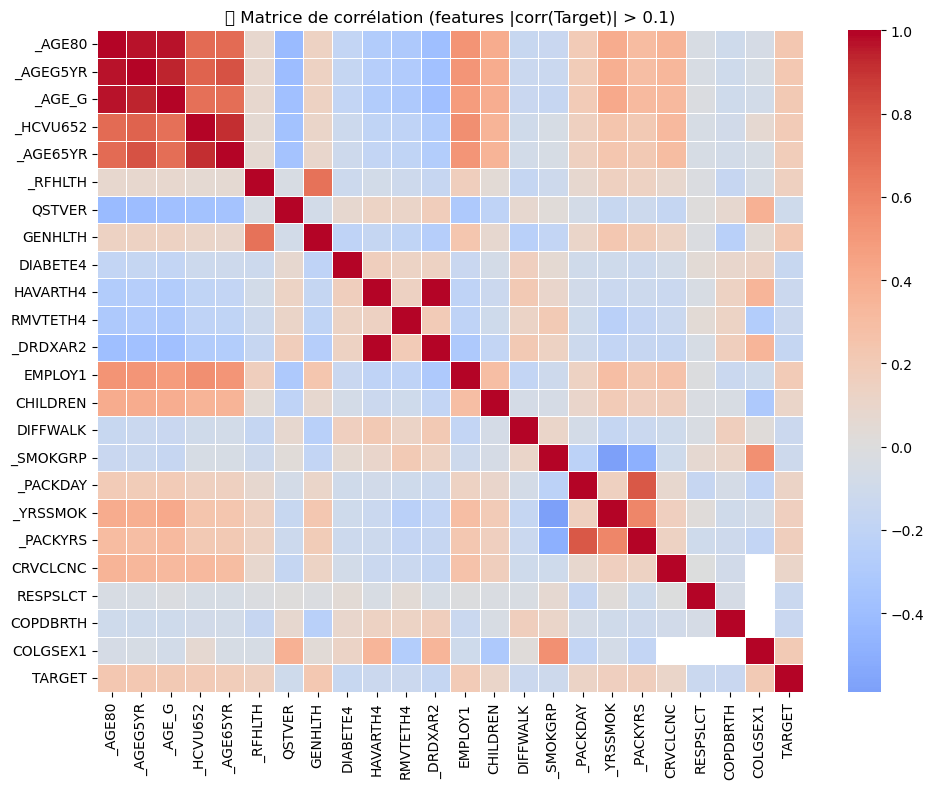

In [53]:
# 6️⃣ Filtrer les features avec |corr| > 0.1
selected_features = summary.loc[summary['corr_with_Target'].abs() > 0.1, 'feature'].tolist()

# 7️⃣ Créer un sous-DataFrame avec ces features + la Target
filtered_df = df_num[selected_features + [target_col]]

# 8️⃣ Calcul de la matrice de corrélation filtrée
corr_matrix_filtered = filtered_df.corr(numeric_only=True)

# 9️⃣ Affichage du heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix_filtered,
    cmap='coolwarm',
    center=0,
    annot=False,
    linewidths=0.5
)
plt.title("🔗 Matrice de corrélation (features |corr(Target)| > 0.1)")
plt.tight_layout()
plt.show()

Test Random Forest 

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import LabelEncoder


# Dataset
original_df_train = pd.read_csv("data/train.csv", delimiter=",")
original_df_test = pd.read_csv("data/test.csv", delimiter=",")

print(f"Train shape : {original_df_train.shape}")
print(f"Test shape  : {original_df_test.shape}")

# Suppression des colonnes avec 100% de NaN
cols_all_nan_train = original_df_train.columns[original_df_train.isna().mean() == 1.0]
df_clean_train = original_df_train.drop(columns=cols_all_nan_train)
print(f"Colonnes supprimées train : {list(cols_all_nan_train)}")
print(f"Train nettoyé : {df_clean_train.shape}")

cols_all_nan_test = original_df_test.columns[original_df_test.isna().mean() == 1.0]
df_clean_test = original_df_test.drop(columns=cols_all_nan_test)
print(f"Colonnes supprimées test : {list(cols_all_nan_test)}")
print(f"Test nettoyé : {df_clean_test.shape}")


# Séparation Train
target_col = df_clean_train.columns[-1]
print(f"Colonne Target : {target_col}")

X = df_clean_train.drop(columns=[target_col])
y = df_clean_train[target_col]

# Copy et séparation dataset 
X = X.copy()
for col in X.select_dtypes(include=['object', 'category']).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,       # important car dataset déséquilibré
    random_state=42
)
print(f"Split : {X_train.shape[0]} train / {X_val.shape[0]} validation")

#Model 
model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
model.fit(X_train, y_train)

# 7️Validation et F1-score

y_pred = model.predict(X_val)
f1 = f1_score(y_val, y_pred)
print(f"\n🔥 F1-score (validation) : {f1:.4f}\n")

# Détails complémentaires
print("Rapport de classification :")
print(classification_report(y_val, y_pred))

Train shape : (225000, 325)
Test shape  : (75000, 324)
Colonnes supprimées train : ['TOLDCFS', 'HAVECFS', 'WORKCFS']
Train nettoyé : (225000, 322)
Colonnes supprimées test : ['TOLDCFS', 'HAVECFS', 'WORKCFS']
Test nettoyé : (75000, 321)
Colonne Target : TARGET
Split : 157500 train / 67500 validation

🔥 F1-score (validation) : 0.0497

Rapport de classification :
              precision    recall  f1-score   support

       False       0.91      1.00      0.95     61458
        True       0.56      0.03      0.05      6042

    accuracy                           0.91     67500
   macro avg       0.74      0.51      0.50     67500
weighted avg       0.88      0.91      0.87     67500



In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import LabelEncoder

# =====================
# 1️⃣ Chargement et nettoyage
# =====================
original_df_train = pd.read_csv("data/train.csv", delimiter=",")
original_df_test = pd.read_csv("data/test.csv", delimiter=",")

# Suppression colonnes 100% NaN
cols_all_nan_train = original_df_train.columns[original_df_train.isna().mean() == 1.0]
df_clean_train = original_df_train.drop(columns=cols_all_nan_train)
cols_all_nan_test = original_df_test.columns[original_df_test.isna().mean() == 1.0]
df_clean_test = original_df_test.drop(columns=cols_all_nan_test)

print(f"🧹 Colonnes supprimées (train) : {list(cols_all_nan_train)}")
print(f"🧹 Colonnes supprimées (test)  : {list(cols_all_nan_test)}")

# =====================
# 2️⃣ Identification de la Target et des features corrélées
# =====================
target_col = df_clean_train.columns[-1]
print(f"🎯 Target : {target_col}")

df_num = df_clean_train.apply(pd.to_numeric, errors='coerce')
corr_matrix = df_num.corr(numeric_only=True)
corr_with_target = corr_matrix[target_col].drop(labels=[target_col], errors='ignore')

# Features corrélées
selected_features = corr_with_target[abs(corr_with_target) > 0.1].index.tolist()
print(f"✅ {len(selected_features)} features retenues (|corr(Target)| > 0.1)")

# =====================
# 3️⃣ Préparation des données
# =====================
X = df_clean_train[selected_features].copy()
y = df_clean_train[target_col]

# Encodage identique des colonnes catégorielles
encoder_dict = {}
for col in X.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    encoder_dict[col] = le  # sauvegarde de l’encodeur pour l’appliquer au test

# =====================
# 4️⃣ Split train / validation
# =====================
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

# =====================
# 5️⃣ Entraînement du modèle
# =====================
model = RandomForestClassifier(
    n_estimators=1000,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
model.fit(X_train, y_train)

# =====================
# 6️⃣ Évaluation sur validation
# =====================
y_pred_val = model.predict(X_val)
f1 = f1_score(y_val, y_pred_val)
print(f"\n🔥 F1-score (validation) : {f1:.4f}\n")
print("📊 Rapport de classification :")
print(classification_report(y_val, y_pred_val))

# =====================
# 7️⃣ Préparation du jeu de test pour la prédiction
# =====================
# On garde uniquement les colonnes présentes dans selected_features
X_test = df_clean_test.reindex(columns=selected_features, fill_value=np.nan).copy()

# Encodage avec les mêmes label encoders (pour les colonnes catégorielles)
for col, le in encoder_dict.items():
    if col in X_test.columns:
        X_test[col] = X_test[col].astype(str)
        X_test[col] = X_test[col].map(lambda x: x if x in le.classes_ else None)
        X_test[col] = le.transform(X_test[col].fillna(le.classes_[0]))

# =====================
# 8️⃣ Prédiction sur le test
# =====================
y_pred_test = model.predict(X_test)

# Si le dataset test a une colonne "Id" (classique Kaggle), on l’utilise
id_col = "ID" if "ID" in df_clean_test.columns else df_clean_test.columns[-1]


# =====================
# 9️⃣ Création du CSV de résultats
# =====================
pred_df = pd.DataFrame({
    id_col: df_clean_test[id_col],
    "pred": y_pred_test
})

pred_df.to_csv("predictions_random_forest.csv", index=False)
print("✅ Fichier exporté : predictions_random_forest.csv")
print(pred_df.head())


🧹 Colonnes supprimées (train) : ['TOLDCFS', 'HAVECFS', 'WORKCFS']
🧹 Colonnes supprimées (test)  : ['TOLDCFS', 'HAVECFS', 'WORKCFS']
🎯 Target : TARGET
✅ 23 features retenues (|corr(Target)| > 0.1)

🔥 F1-score (validation) : 0.1512

📊 Rapport de classification :
              precision    recall  f1-score   support

       False       0.92      0.97      0.94     61458
        True       0.25      0.11      0.15      6042

    accuracy                           0.89     67500
   macro avg       0.58      0.54      0.55     67500
weighted avg       0.86      0.89      0.87     67500

✅ Fichier exporté : predictions_random_forest.csv
       ID   pred
0  225000  False
1  225001  False
2  225002  False
3  225003  False
4  225004   True


In [54]:
# Showing a bit of the dataset
original_df.head()

# Checking the number of benign (result = 0) and malware (result = 1) apps
pred_df_false = original_df[original_df["TARGET"] == 0]
pred_df_true = original_df[original_df["TARGET"] == 1]

print(f"False data shape : {pred_df_false.shape}")
print(f"False data shape : {pred_df_true.shape}")
print(pred_df_true.shape[0]/(pred_df_false.shape[0]+pred_df_true.shape[0]))

False data shape : (204861, 325)
False data shape : (20139, 325)
0.08950666666666666
